In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.fft as fft

In [2]:
electrode_names = [
    "FP1", "FPz", "FP2", "AFp1", "AFPz", "AFp2", "AF7", "AF3", "AF4", "AF8",
    "AFF5h", "AFF1h", "AFF2h", "AFF6h", "F9", "F7", "F5", "F3", "F1", "Fz",
    "F2", "F4", "F6", "F8", "F10", "FFT9h", "FFT7h", "FFC5h", "FFC3h", "FFC1h",
    "FFC2h", "FFC4h", "FFC6h", "FFT8h", "FFT10h", "FT9", "FT7", "FC5", "FC3",
    "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "FT10", "FTT9h", "FTT7h", "FCC5h",
    "FCC3h", "FCC1h", "FCC2h", "FCC4h", "FCC6h", "FTT8h", "FTT10h", "T7", "C5",
    "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TTP7h", "CCP5h", "CCP3h", "CCP1h",
    "CCP2h", "CCP4h", "CCP6h", "TTP8h", "TP9", "TP7", "CP5", "CP3", "Cpz", "CP4",
    "CP6", "TP8", "TP10", "TPP9h", "TPP7h", "CPP5h", "CPP3h", "CPP1h", "CPP2h",
    "CPP4h", "CPP6h", "TPP8h", "TPP10h", "P9", "P7", "P5", "P3", "P1", "Pz", "P2",
    "P4", "P6", "P8", "P10", "PPO9h", "PPO5h", "PPO1h", "PPO2h", "PPO6h", "PPO10h",
    "PO9", "PO7", "PO3", "POz", "PO4", "PO8", "PO10", "POO9h", "POO1", "POO2",
    "POO10h", "O1", "Oz", "O2", "OI1h", "OI2h", "I1", "Iz", "I2"
]

num_electrodes = len(electrode_names)

num_electrodes
NUM_CHANNELS_TO_LOAD = 128
DATA_SIZE = 60_000
SIGNAL_LENGTH = 167

In [3]:
labels = np.zeros(DATA_SIZE, dtype=int)
data = np.zeros((DATA_SIZE, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH))

def data_selection():
    class_means = np.zeros((10, 128, 167))
    for i in tqdm(range(10)):
        class_means[i] = np.mean(data[labels == i], axis=0)
    z = np.zeros(DATA_SIZE)
    for i in tqdm(range(DATA_SIZE)):
        j = labels[i]
        x = data[i]
        z[i] = np.corrcoef(x, class_means[j])[0][1]
    return z

def load_channel(channel: int, cz: int):
    i = 0
    csize = cz
    for chunk in tqdm(pd.read_csv('/kaggle/input/processed-train/processed_train.csv', chunksize=cz)):
        labels[i*csize:(i+1)*csize] = chunk['label'].to_numpy()
        data[i*csize:(i+1)*csize] = chunk.iloc[0:csize, :-2].to_numpy().reshape((csize,NUM_CHANNELS_TO_LOAD,SIGNAL_LENGTH))[:,channel:channel+NUM_CHANNELS_TO_LOAD,:].reshape((csize, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH))
        i = i + 1
        if i == (DATA_SIZE / csize):
            break
    
        

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from multiprocessing import Pool, Pipe
from itertools import combinations

n_neighbors = 109

def do_work(i):
    nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    result = np.zeros((10,10))
    for e, x in enumerate(combinations(nums, 2)):
        j, l = x
        y = labels[(labels == j) | (labels == l)]
        d = data[(labels == j) | (labels == l)]
        X_train, X_test, y_train, y_test = train_test_split(d[:,i,:], y, test_size=0.2, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        a = accuracy_score(y_test, y_pred)
        result[j, l] = a
        result[l, j] = a
    r = result.flatten()
    r = r[r != 0]
    print("i: " + str(i) + ": " + str(np.mean(r)))
    return result


def classify_all_nums():
    with Pool() as pool:
        accuracies = pool.map(do_work, range(NUM_CHANNELS_TO_LOAD))
    return accuracies



In [5]:
load_channel(0, 1000)

59it [12:26, 12.65s/it]


In [6]:
# z = data_selection()
# data = data[np.abs(z) >= 0.3]
# print(data.shape)
# labels = labels[np.abs(z) >= 0.3]


In [7]:
a = classify_all_nums()

i: 8: 0.5049785953911714
i: 16: 0.5070171659850413
i: 24: 0.511809501274327
i: 0: 0.504934378788149
i: 9: 0.5098464276087469
i: 17: 0.5056414346316617
i: 25: 0.5094743613557701
i: 1: 0.504784972260885
i: 10: 0.5081617040956716
i: 18: 0.5050741440361027
i: 2: 0.5082522280736181
i: 26: 0.5069614033072884
i: 11: 0.5071548639082171
i: 19: 0.5061879349054076
i: 3: 0.5058289932727289
i: 27: 0.5086550809949231
i: 12: 0.5059464827602272
i: 28: 0.5078724081526911
i: 20: 0.508302813126738
i: 4: 0.5060423685866783
i: 13: 0.5048699562576936
i: 21: 0.5076177102307275
i: 29: 0.507973826586066
i: 5: 0.5061601638861185
i: 14: 0.5057984283416815
i: 22: 0.5088010314890761
i: 30: 0.5037442278074076
i: 6: 0.507243750979469
i: 15: 0.507062253209268
i: 23: 0.5091848580503424
i: 31: 0.5067976859391125
i: 7: 0.5089968240265633
i: 32: 0.5069011138587008
i: 40: 0.5071697466012576
i: 48: 0.5058226688477607
i: 56: 0.5050063176786154
i: 33: 0.5080791956914976
i: 41: 0.5031786295228065
i: 49: 0.5082980440173779
i: 

/tmp/ipykernel_18/3281820150.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  v = cm.get_cmap('viridis', 5)


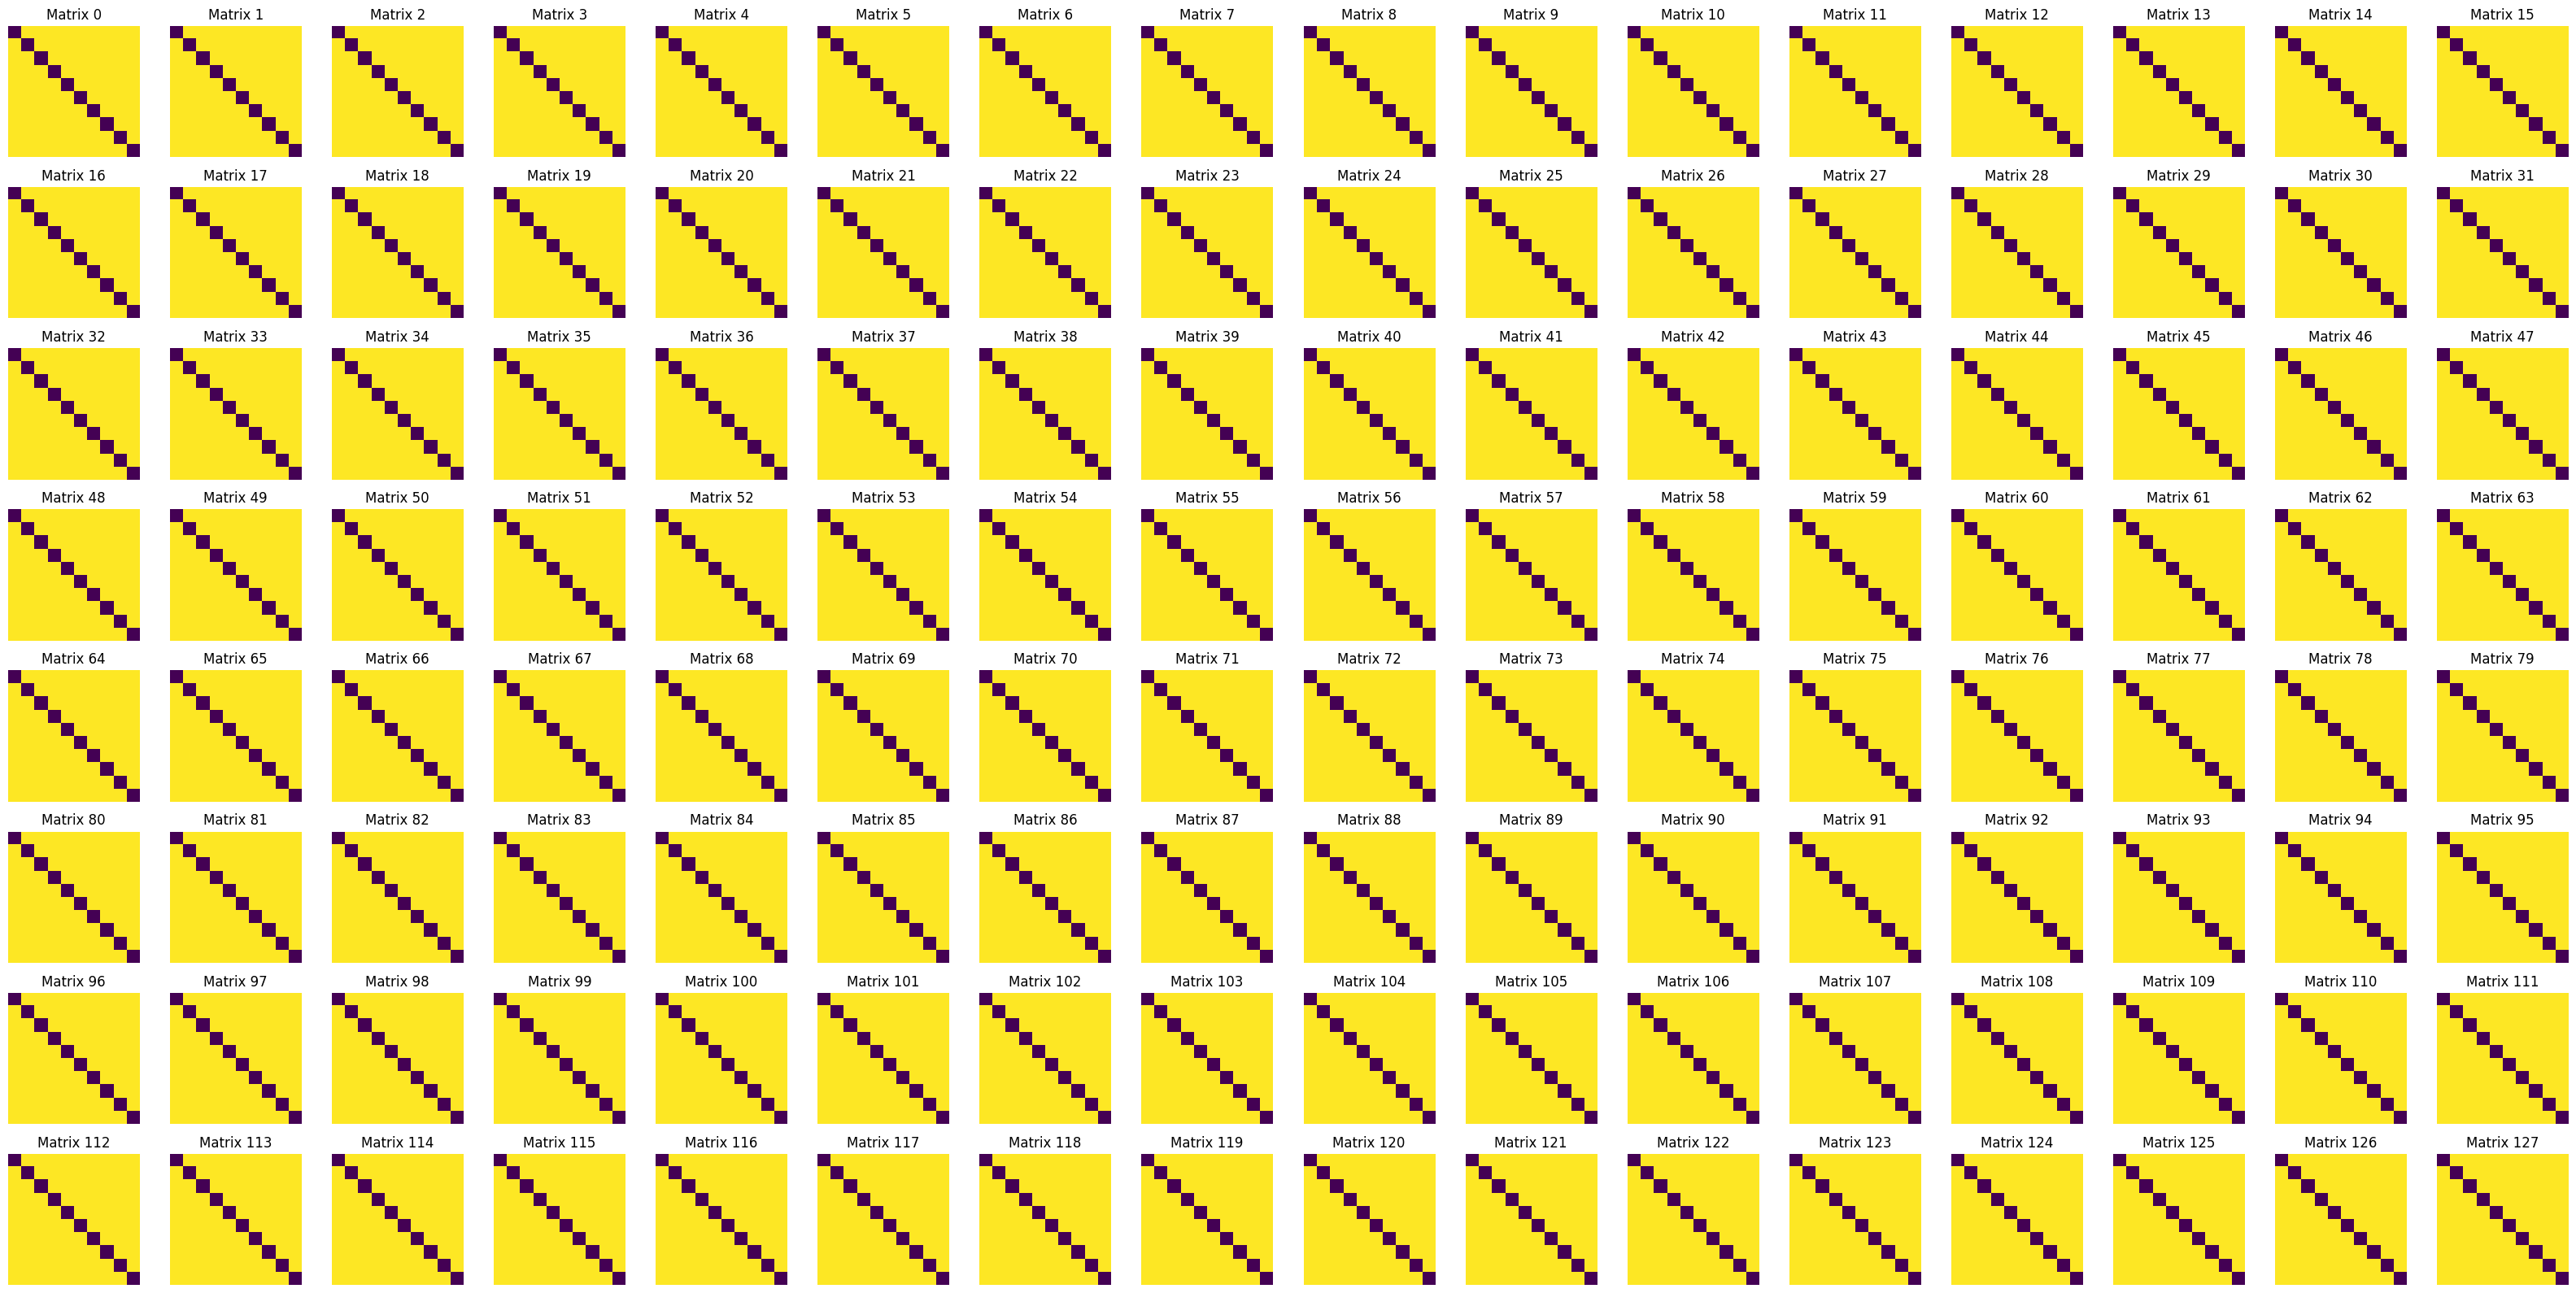

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

a = np.array(a)
num_matrices = a.shape[0]
rows = 8
cols = num_matrices // rows if num_matrices % rows == 0 else num_matrices // rows + 1  # Number of columns

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

v = cm.get_cmap('viridis', 5)
for i in range(num_matrices):
    row = i // cols
    col = i % cols
    
    axes[row, col].imshow(a[i], cmap=v)
    axes[row, col].set_title(f'Matrix {i}')
    axes[row, col].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



In [9]:
best = []
for i in range(10):
    for j in range(10):
        if i == j:
            break
        max = np.max(a[:,i,j])
        index = np.argmax(a[:,i,j])
        best.append(index)
        print(f"Max accuracy for {i} and {j} is {max} at channel {index}")
print(len(best))
bset = set(best)
print(len(bset))
print(bset)

Max accuracy for 1 and 0 is 0.5444137386498223 at channel 34
Max accuracy for 2 and 0 is 0.5334455195624737 at channel 27
Max accuracy for 2 and 1 is 0.5326771653543307 at channel 10
Max accuracy for 3 and 0 is 0.5217751970136872 at channel 18
Max accuracy for 3 and 1 is 0.5332038834951456 at channel 27
Max accuracy for 3 and 2 is 0.5306038047973531 at channel 17
Max accuracy for 4 and 0 is 0.5325116872078198 at channel 24
Max accuracy for 4 and 1 is 0.5411203814064363 at channel 56
Max accuracy for 4 and 2 is 0.5258474576271186 at channel 7
Max accuracy for 4 and 3 is 0.5281837160751566 at channel 124
Max accuracy for 5 and 0 is 0.5354781842221242 at channel 72
Max accuracy for 5 and 1 is 0.5618577887381833 at channel 24
Max accuracy for 5 and 2 is 0.5461335676625659 at channel 53
Max accuracy for 5 and 3 is 0.531371700562527 at channel 108
Max accuracy for 5 and 4 is 0.5295162006213937 at channel 124
Max accuracy for 6 and 0 is 0.5238497256226256 at channel 33
Max accuracy for 6 and 

In [10]:
# get the 16 channels with the highest accuracy
channels = []
temp = []
for t in a:
    temp.append(np.mean(t))

temp = np.array(temp)
    
for i in range(16):
    m = np.max(temp)
    index = np.argmax(temp)
    channels.append(index)
    temp = temp[temp != m]
print(channels)

[24, 9, 103, 23, 120, 22, 7, 20, 80, 90, 21, 53, 36, 18, 40, 2]


In [11]:
for c in channels:
    best.append(c)
bset = set(best)
print(len(bset))
print(bset)

43
{1, 2, 7, 9, 10, 11, 15, 17, 18, 20, 21, 22, 23, 24, 27, 33, 34, 36, 37, 38, 39, 40, 46, 48, 49, 52, 53, 54, 56, 60, 72, 77, 79, 80, 90, 97, 103, 105, 106, 108, 114, 120, 124}


In [12]:
for c in combinations([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 2):
    x, y = c
    i = labels[labels==x].shape[0]
    j = labels[labels==y].shape[0]
    print(f"Class {x} has {i} samples, class {y} has {j} samples")
    print(f"Ratio is {i/j}")

Class 0 has 5923 samples, class 1 has 6742 samples
Ratio is 0.878522693562741
Class 0 has 5923 samples, class 2 has 5958 samples
Ratio is 0.9941255454850622
Class 0 has 5923 samples, class 3 has 6131 samples
Ratio is 0.966074049910292
Class 0 has 5923 samples, class 4 has 5842 samples
Ratio is 1.0138651146867512
Class 0 has 5923 samples, class 5 has 5421 samples
Ratio is 1.0926028408042796
Class 0 has 5923 samples, class 6 has 5918 samples
Ratio is 1.0008448800270362
Class 0 has 5923 samples, class 7 has 6265 samples
Ratio is 0.9454110135674382
Class 0 has 5923 samples, class 8 has 5850 samples
Ratio is 1.0124786324786326
Class 0 has 5923 samples, class 9 has 5949 samples
Ratio is 0.9956295175659775
Class 1 has 6742 samples, class 2 has 5958 samples
Ratio is 1.131587781134609
Class 1 has 6742 samples, class 3 has 6131 samples
Ratio is 1.0996574783885174
Class 1 has 6742 samples, class 4 has 5842 samples
Ratio is 1.1540568298527902
Class 1 has 6742 samples, class 5 has 5421 samples
Rati